In [178]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!git clone https://github.com/ekaramustafa/diffposenet.git

Cloning into 'diffposenet'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 158 (delta 80), reused 108 (delta 47), pack-reused 0 (from 0)
Receiving objects: 100% (158/158), 50.50 KiB | 4.59 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [171]:
def compute_image_gradients(image_tensor):
    """
    Computes ∇I = (∂I/∂x, ∂I/∂y) given an input image tensor.
    """

    # --- Prepare the input tensor ---
    x = image_tensor.unsqueeze(0).float()

    # --- Define Sobel filters ---
    sobel_x = np.array([[1, 0, -1],
                        [2, 0, -2],
                        [1, 0, -1]], dtype=np.float32)

    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]], dtype=np.float32)

    # --- Create convolution layers with Sobel kernels ---
    conv_x = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False).float()
    conv_y = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False).float()

    # Assign weights
    conv_x.weight = nn.Parameter(torch.from_numpy(sobel_x).unsqueeze(0).unsqueeze(0))
    conv_y.weight = nn.Parameter(torch.from_numpy(sobel_y).unsqueeze(0).unsqueeze(0))

    # --- Compute gradients ---
    grad_x = conv_x(x).squeeze(0)
    grad_y = conv_y(x).squeeze(0)

    return grad_x, grad_y

In [172]:
def compute_normal_flow(opt_flow: torch.tensor, img_pair: torch.tensor):
    """
    Args:
        opt_flow: (2, H, W) tensor containing horizontal (u) and vertical (v) optical flow components
        image_pair: (6, H, W) tensor containing concatenated image pairs (e.g., [img1, img2])

    Returns:
        normal_flow_magnitude: (1, H, W) tensor containing normal flow magnitude for the image pair
    """
    grayscale_transform = Grayscale(num_output_channels=1)

    u = opt_flow[0:1, :, :]
    v = opt_flow[1:2, :, :]

    ref_img_gray = grayscale_transform(img_pair[:3, :, :])

    grad_x, grad_y = compute_image_gradients(ref_img_gray)
    grad_norm_sq = grad_x ** 2 + grad_y ** 2
    grad_norm_sq[grad_norm_sq == 0] = 1e-6

    dot_product = u * grad_x + v * grad_y
    scale = dot_product / grad_norm_sq

    n_x = scale * grad_x
    n_y = scale * grad_y

    normal_flow_magnitude = torch.sqrt(n_x ** 2 + n_y ** 2)
    return normal_flow_magnitude

In [173]:
import torch
import numpy as np
from PIL import Image
import glob
from torch.utils.data import Dataset
import torchvision.transforms as transforms


class PairedImageDataset(Dataset):
    def __init__(self, img_folder_path, opt_flow_folder_path):
        self.image_paths = sorted(glob.glob(img_folder_path + '/*.png'))
        self.opt_flow_paths = sorted(glob.glob(opt_flow_folder_path + '/*_flow.npy'))
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths) - 1

    def __getitem__(self, idx):
        # Load two consecutive images
        img1 = Image.open(self.image_paths[idx]).convert('RGB')
        img2 = Image.open(self.image_paths[idx + 1]).convert('RGB')
        img1 = self.transform(img1)
        img2 = self.transform(img2)

        paired = torch.cat((img1, img2), dim=0)

        opt_flow = np.load(self.opt_flow_paths[idx])
        opt_flow = torch.from_numpy(opt_flow).permute(2, 0, 1).float()

        normal_flow = compute_normal_flow(opt_flow, paired)
        return paired, normal_flow

In [174]:
img_file_path = '/content/drive/My Drive/P008/image_left'
opt_flow_file_path = '/content/drive/My Drive/P008/flow'

dataset = PairedImageDataset(img_file_path, opt_flow_file_path)

Initial Test Loss (Before Training): 63.6846


Epoch [1/10]: 100%|██████████| 65/65 [01:22<00:00,  1.27s/it, Batch Loss=56.3]


Epoch [1/10], Avg Train Loss: 65.9965
Epoch [1/10], Test Loss: 38.5648


Epoch [2/10]: 100%|██████████| 65/65 [01:47<00:00,  1.65s/it, Batch Loss=41.9]


Epoch [2/10], Avg Train Loss: 38.3618
Epoch [2/10], Test Loss: 25.7775


Epoch [3/10]: 100%|██████████| 65/65 [02:10<00:00,  2.01s/it, Batch Loss=11.6]


Epoch [3/10], Avg Train Loss: 26.4385
Epoch [3/10], Test Loss: 19.5235


Epoch [4/10]: 100%|██████████| 65/65 [02:15<00:00,  2.09s/it, Batch Loss=12.2]


Epoch [4/10], Avg Train Loss: 22.8273
Epoch [4/10], Test Loss: 16.0061


Epoch [5/10]: 100%|██████████| 65/65 [02:17<00:00,  2.11s/it, Batch Loss=21.7]


Epoch [5/10], Avg Train Loss: 21.8065
Epoch [5/10], Test Loss: 16.9652


Epoch [6/10]: 100%|██████████| 65/65 [02:11<00:00,  2.02s/it, Batch Loss=27.8]


Epoch [6/10], Avg Train Loss: 21.5691
Epoch [6/10], Test Loss: 17.4715


Epoch [7/10]: 100%|██████████| 65/65 [02:10<00:00,  2.01s/it, Batch Loss=16.1]


Epoch [7/10], Avg Train Loss: 21.0089
Epoch [7/10], Test Loss: 21.4917


Epoch [8/10]: 100%|██████████| 65/65 [02:13<00:00,  2.05s/it, Batch Loss=79.9]


Epoch [8/10], Avg Train Loss: 20.5033
Epoch [8/10], Test Loss: 15.4162


Epoch [9/10]: 100%|██████████| 65/65 [01:56<00:00,  1.79s/it, Batch Loss=28.6]


Epoch [9/10], Avg Train Loss: 19.9960
Epoch [9/10], Test Loss: 18.7604


Epoch [10/10]: 100%|██████████| 65/65 [01:34<00:00,  1.46s/it, Batch Loss=44.9]


Epoch [10/10], Avg Train Loss: 20.3619
Epoch [10/10], Test Loss: 17.2036


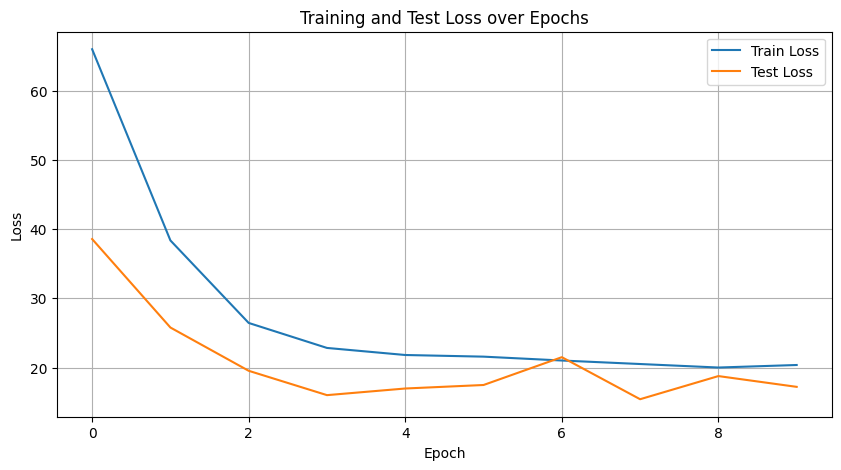

In [175]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from tqdm import tqdm

from model import NFlowNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

img_file_path = '/content/drive/My Drive/P008/image_left'
opt_flow_file_path = '/content/drive/My Drive/P008/flow'
dataset = PairedImageDataset(img_file_path, opt_flow_file_path)

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


model = NFlowNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

train_losses = []
test_losses = []

# ----- Compute Initial Loss (Before any training) -----
model.eval()
initial_test_loss = 0.0
with torch.no_grad():
    for paired_batch, normal_flow_batch in test_loader:
        paired_batch, normal_flow_batch = paired_batch.to(device), normal_flow_batch.to(device)
        outputs = model(paired_batch)

        loss = criterion(outputs, normal_flow_batch)
        initial_test_loss += loss.item()

initial_test_loss /= len(test_loader)
print(f"Initial Test Loss (Before Training): {initial_test_loss:.4f}")

# ----- Training Loop -----
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    batch_losses = []

    # Wrap train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{num_epochs}]")

    for paired_batch, normal_flow_batch in pbar:
        paired_batch, normal_flow_batch = paired_batch.to(device), normal_flow_batch.to(device)

        optimizer.zero_grad()
        outputs = model(paired_batch)

        loss = criterion(outputs, normal_flow_batch)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        batch_losses.append(loss.item())

        # Update progress bar with current batch loss
        pbar.set_postfix({'Batch Loss': loss.item()})

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Avg Train Loss: {avg_train_loss:.4f}")

    # ----- Evaluate on Test Data -----
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for paired_batch, normal_flow_batch in test_loader:
            paired_batch, normal_flow_batch = paired_batch.to(device), normal_flow_batch.to(device)
            outputs = model(paired_batch)
            loss = criterion(outputs, normal_flow_batch)
            running_test_loss += loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}")

# ----- Plotting -----
plt.figure(figsize=(10,5))
plt.plot(range(num_epochs), train_losses, label="Train Loss")
plt.plot(range(num_epochs), test_losses, label="Test Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()